In [1]:

##Server
import socket, time, sys , serial
import threading
import pprint
import time
from TCP_server import *
from Serial_ import *
SERIAL_PORT_ROBOT = '/dev/ttyACM0'
SERIAL_PORT_COllECTOR = '/dev/ttyACM1'
SERIAL_RATE = 115200
import threading
from collections import deque

clientCount = 0


buf_broadcast = deque([]) # Queue of message for broadcasting via TCP IP
buf_stm = deque([])

buf_stm


if __name__ == '__main__':
    ser = serial.Serial(SERIAL_PORT_ROBOT, SERIAL_RATE) # Connection to STM32 ROBOT
    #s = server() #create new server listening for connections
    serial_T = serialTread(ser)
    #threading.Thread(target=s.startServer,args=(buf_broadcast,buf_stm,clientCount)).start()#create server thread
    threading.Thread(target=serial_T.run, args=(buf_broadcast,buf_stm)).start()#create serial thread for robot control
    
    time.sleep(1)

#Changer les action_In et action_Out en queue de dictionaire

In [2]:
import numpy as np
print('Numpy')

import math
print('Math')

import robot as Robot
print('Robot')

from Astar import *
print('Astar')

from Mapping import *
print('Mapping')

import matplotlib.pyplot as plt
print('Matplotlib')

from parse import *
print('parse')

%matplotlib inline

Numpy
Math
Robot
Astar
Custom
Matplotlib
parse


In [3]:
buf_stm.append("G92 X1500 Y250 A0\r\n")
print('Position Set')
robot = Robot.robot(1500,250,0)
robot.set_position(1500,250,0)
print('Robot objet Set')

mapper = Mapping()
print('Map objet Set')

Set_Objective=[[100,250]]


Position Set
Robot objet Set
Map objet Set


[[1500.          250.          500.          500.        ]
 [1660.          550.          500.         1452.        ]
 [1530.          640.          500.          942.71887242]
 [ 980.          610.          500.         2042.28920764]
 [ 620.          250.          500.         1925.52727087]
 [ 100.          250.          500.         1956.        ]]
OK: X=1500.00 Y=250.00 A=0.00 T=500.00

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X1500.00 Y250.00 A0.00 T1 S0

Timeout
OK: X=1660.00 Y=550.00 A=0.00 T=1452.00

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X1637.05 Y380.71 A79.89 T1 S0

Timeout
OK: X=1530.00 Y=640.00 A=0.00 T=942.72

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X1619.73 Y518.91 A120.24 T1 S0

Timeout
OK: X=980.00 Y=610.00 A=0.00 T=2042.29

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X1141.23 Y664.26 A197.58 T1 S0

Timeout
OK: X=620.00 Y=250.00 A=0.00 T=1925.53

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X849.49 Y535.48 A186.19 T1 S0

Timeou

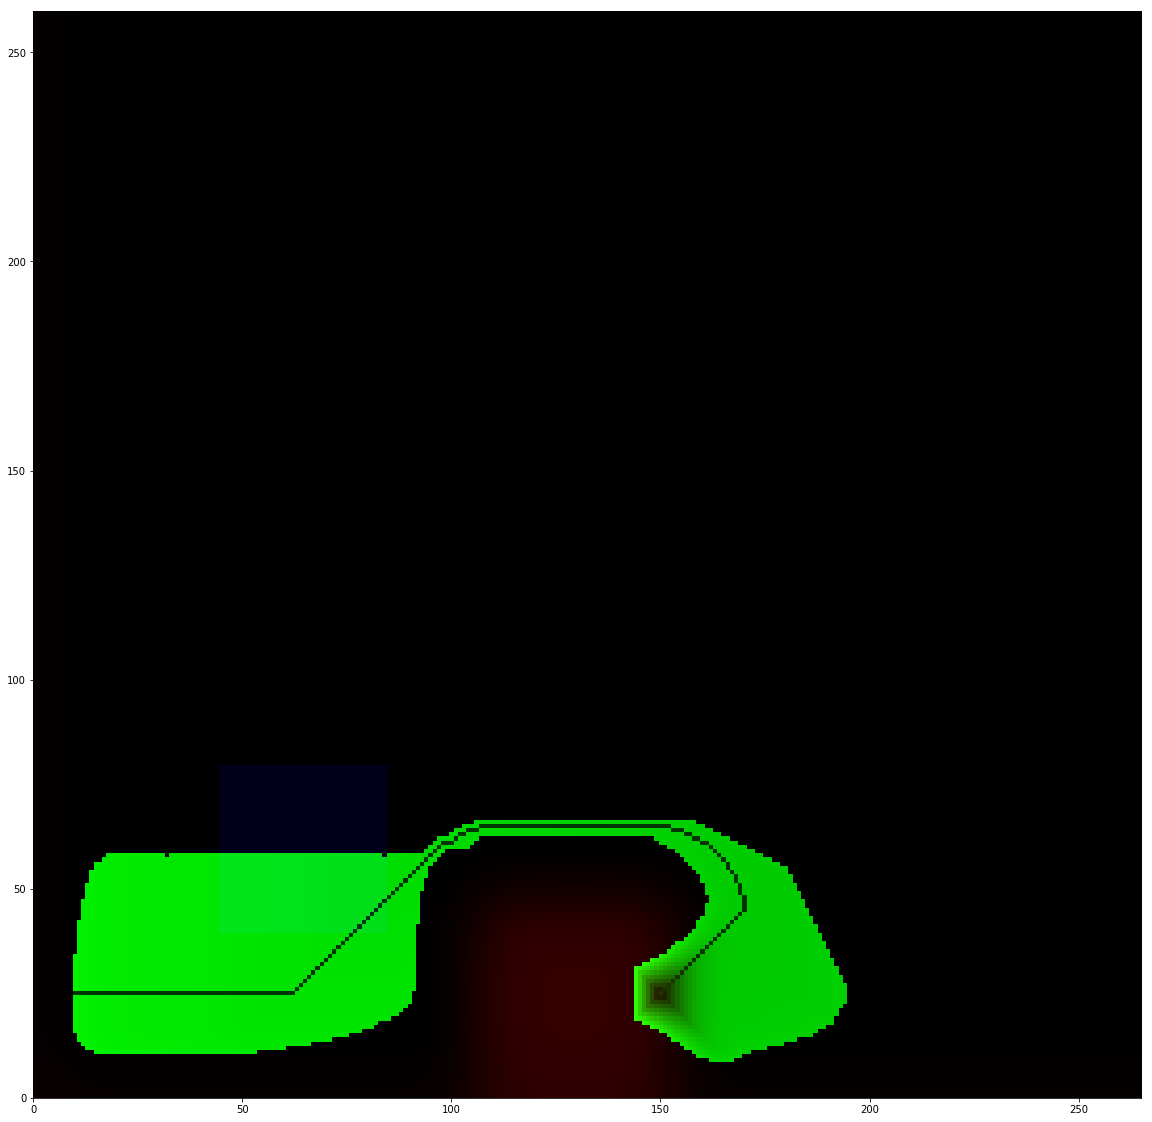

In [5]:
obstacleFront = 0

grid = mapper.map()#Get the actual Map
Get_Pos=robot.get_position()# Get the actual robot Position
path, cost , G = AStarSearch((Get_Pos[0],Get_Pos[1]), (Set_Objective[0][0],Set_Objective[0][1]), grid) #Try to find the best path
checkpoint = find_vertice(path)#Simplify the path to be straight line
new_x,newy,theta_robot = checkpoint_in_fov(robot,checkpoint)#Try to avoid backward movement unless it is too far back
checkpoint = checkpoint_corrector(checkpoint)#Eliminate again some short path line   
checkpoint = np.insert(checkpoint,0,[new_x,newy]).reshape((-1,2))# Add repositionning for avoiding backward movement
"""Concatenate Displacement Movement"""
Set_Coordinate=np.zeros((len(checkpoint),4))
Set_Coordinate[:,0]=checkpoint[:,0]
Set_Coordinate[:,1]=checkpoint[:,1]
Set_Coordinate[:,2]=500;
Set_Coordinate[:,3]=8000;
"""Calculate Optimal Timeout"""
tempX , tempY, _  = robot.get_position()
for i in range(len(Set_Coordinate)): 
    time_out_com = math.sqrt( np.float_power(Set_Coordinate[i,0]-tempX , 2) + np.float_power(Set_Coordinate[i,1]-tempY , 2) ) / Set_Coordinate[i,2]
    Set_Coordinate[i,3] = time_out_com*1400 + 500# 140 %(For incertenties +500 ms(For initial acceleration)
    tempX = Set_Coordinate[i,0]
    tempY = Set_Coordinate[i,1]
print(Set_Coordinate)
"""Beginning of the loop for each coordinate the robot has to go through"""

buf_broadcast.clear()#CLear receiving buffer
Offset_Timeout=1500;#Raspberry timeout for lack of communication 
Max_Try=2;#Number of try to send that message
Try =0
j=0
while j <len(Set_Coordinate):
    """Get information of one movement"""
    X_Des=Set_Coordinate[j][0]
    Y_Des=Set_Coordinate[j][1]
    Max_Speed=Set_Coordinate[j][2]
    TimeOut=Set_Coordinate[j][3]
    """Create messages"""
    G0_String='G0 X' + str(X_Des)+' Y'+str(Y_Des)+' T'+str(TimeOut)+'\r\n'
    M201_String='M201 H0 S' + str(Max_Speed)+'\r\n'
    M3_String='M3 H3\r\n'
    All_Commands=[G0_String,M201_String,M3_String]
    Finished=0
    Saved_Time=time.time()
    for i in range(0,len(All_Commands)):
        buf_stm.append(All_Commands[i])#Send every messages
    while(Finished==0 and ((time.time()-Saved_Time)<(Set_Coordinate[j][3]+Offset_Timeout)/1000)) :
        #No "M0" message from the STM32 and still on time according to the Raspi
        if(buf_broadcast):
            received=buf_broadcast.popleft()
            print(received)
            str2=parse("M{} X{} Y{} A{} T{} S{}",received)
            if(str2 is not None):
                array_argument=np.zeros(6)
                for i in range(0,6):
                    array_argument[i]=float(str2[i])
                if (array_argument[0]==0):
                    robot.set_position(array_argument[1],array_argument[2],array_argument[3])
                    if array_argument[4]==0: #T0 argument Arrived or sensor
                        Finished=1#M0 has been received, do the next command
                        print('Finished')
                    else:
                        Finished=1
                        print('Timeout')
                    feedback_sensors = int(array_argument[5])# feedback sensor MLKJIHGFEDCBA    
                    robot.sensor_state(state):
                else:
                    print('Not M0 Frame',array_argument[0])
            else:#Not an M0 frame 
                pass
    if(Finished==0 and Try<Max_Try):
        print('Lack of answer from STM32, Try Number '+str(Try+1))
        Try=Try+1
    else:
        j=j+1
        Try =0
    """End of try for one coordinate"""

mapper.display(G,path,robot)
print('End of total movement')        

In [ ]:
%autoreload 2

In [ ]:
A = np.zeros((self.H,self.W,3))    
A[:,:,0] = self.grid[:,:]

for coord in G:
  A[coord[0],coord[1],1] = G[coord[0],coord[1]]
for coord in path:
  A[coord[1],coord[0],1] = 255
Robot_Array=self.Get_Display_Pos_Robot(robot)

A[:,:,2]=Robot_Array
A[:,:,0]=A[:,:,0]/np.max(A[:,:,0])
A[:,:,1]=A[:,:,1]/np.max(A[:,:,1])
A[:,:,2]=A[:,:,2]/np.max(A[:,:,2])
A=mapper.display(G,path,robot)


[0, 265, 0, 260]

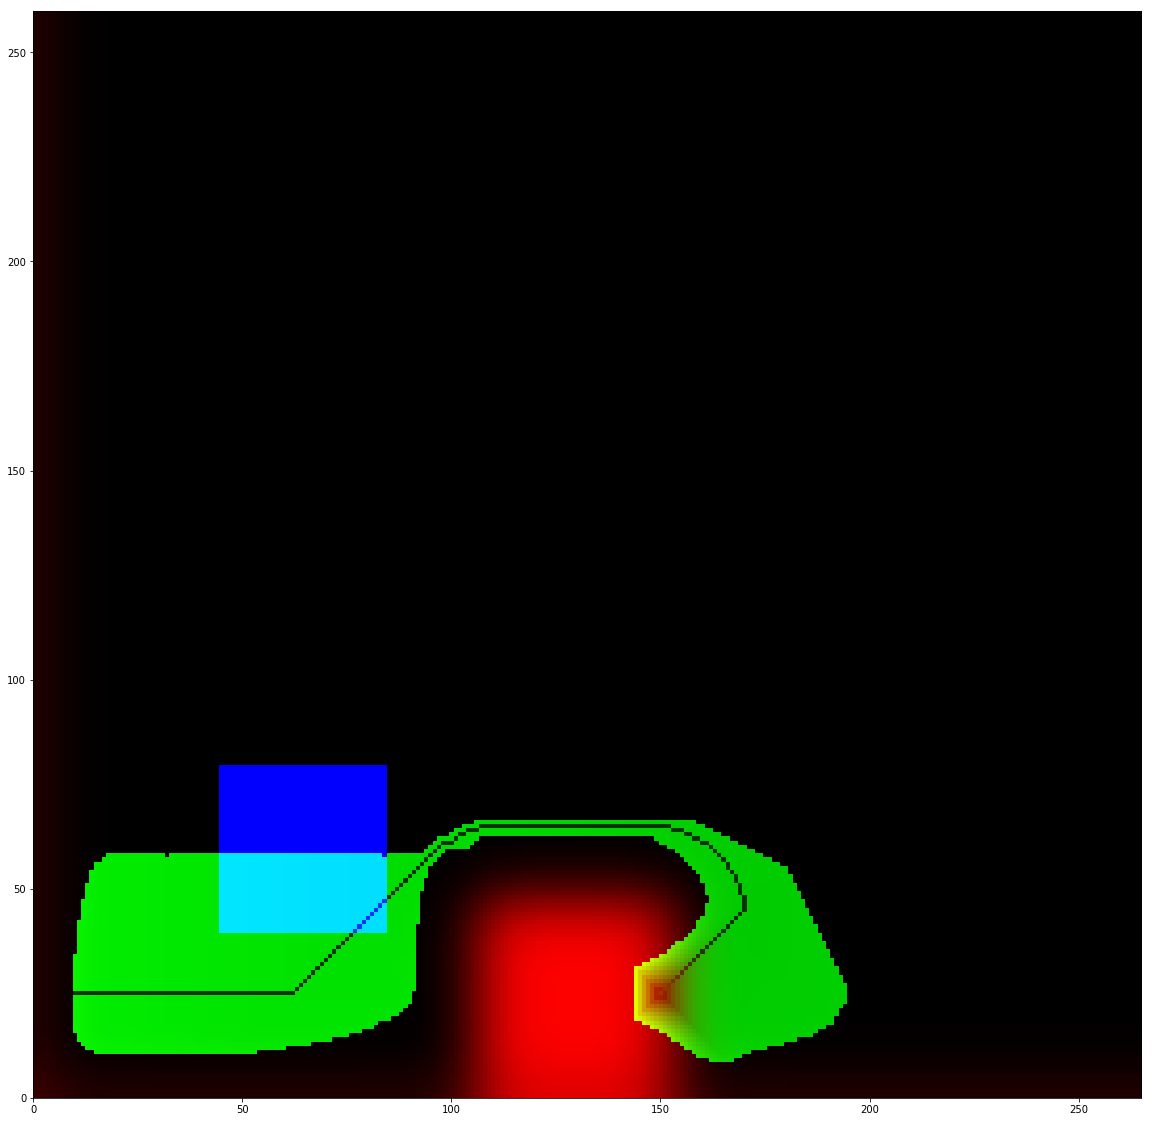

In [10]:
A[:,:,0]=A[:,:,0]/np.max(A[:,:,0])
A[:,:,1]=A[:,:,1]/np.max(A[:,:,1])
A[:,:,2]=A[:,:,2]/np.max(A[:,:,2])
    
plt.figure(figsize=(20,20))
plt.imshow(A,origin='lower')

plt.axis([max(0,robot.x-200),min(800,robot.x+200),max(0,robot.y-200),min(800,robot.y+200)])

In [ ]:
%load_ext autoreload


[[ 460   90]
 [ 460   30]
 [ 920   20]
 [1000  100]
 [1000  250]]
30 25


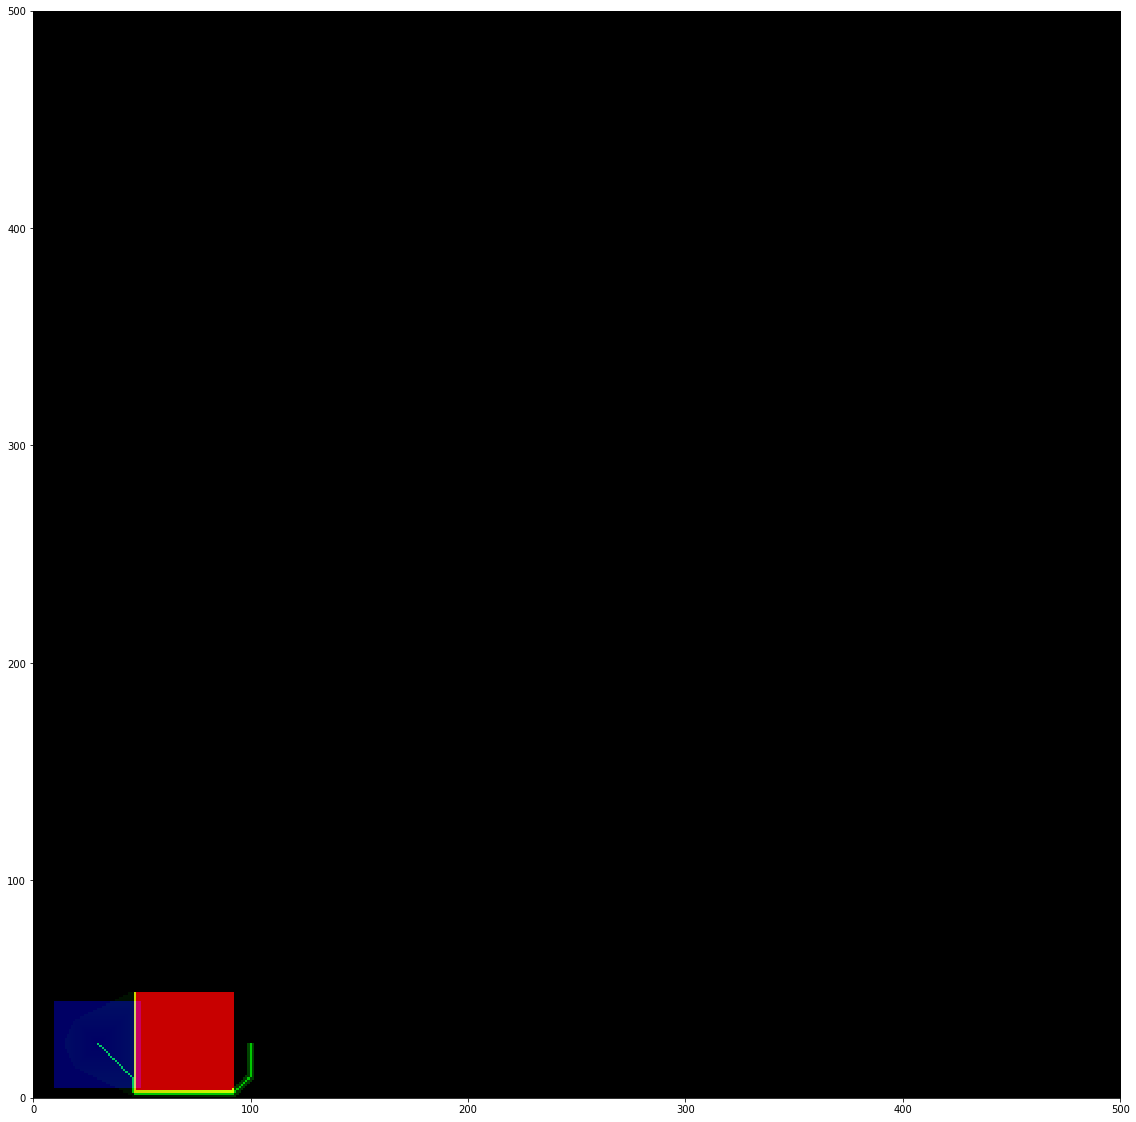

In [5]:
grid_updated=mapper.map()
Get_Pos=robot.get_position()
path, cost , G = AStarSearch((Get_Pos[0],Get_Pos[1]), (1000,250), grid_updated)
checkpoint = find_vertice(path)
new_x,newy,theta_robot = checkpoint_in_fov(robot,checkpoint)
checkpoint=np.array(checkpoint)
print(checkpoint)
print(robot.x,robot.y)
mapper.display(G,path,robot)

In [ ]:

while(buf_broadcast):
    received=buf_broadcast.popleft()
    print(received)

[[   0 2000]]
200 200
1850.0 2000.0 180.0
1700.0 2000.0 180.0
1550.0 2000.0 180.0
backward
[[1970 2030]
 [1970 2090]
 [1980 2190]
 [1990 2230]
 [2000 2260]
 [2030 2300]
 [2100 2370]
 [2160 2390]
 [2620 2400]
 [2670 2380]
 [3000 2070]
 [3000 2000]]


array([[[0.21259843, 0.        , 0.        ],
        [0.21259843, 0.        , 0.        ],
        [0.20866142, 0.        , 0.        ],
        ...,
        [1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        ]],

       [[0.21259843, 0.        , 0.        ],
        [0.21259843, 0.        , 0.        ],
        [0.20866142, 0.        , 0.        ],
        ...,
        [1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        ]],

       [[0.20866142, 0.        , 0.        ],
        [0.20866142, 0.        , 0.        ],
        [0.20472441, 0.        , 0.        ],
        ...,
        [1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        ]],

       ...,

       [[1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        ],
        [1.        , 0

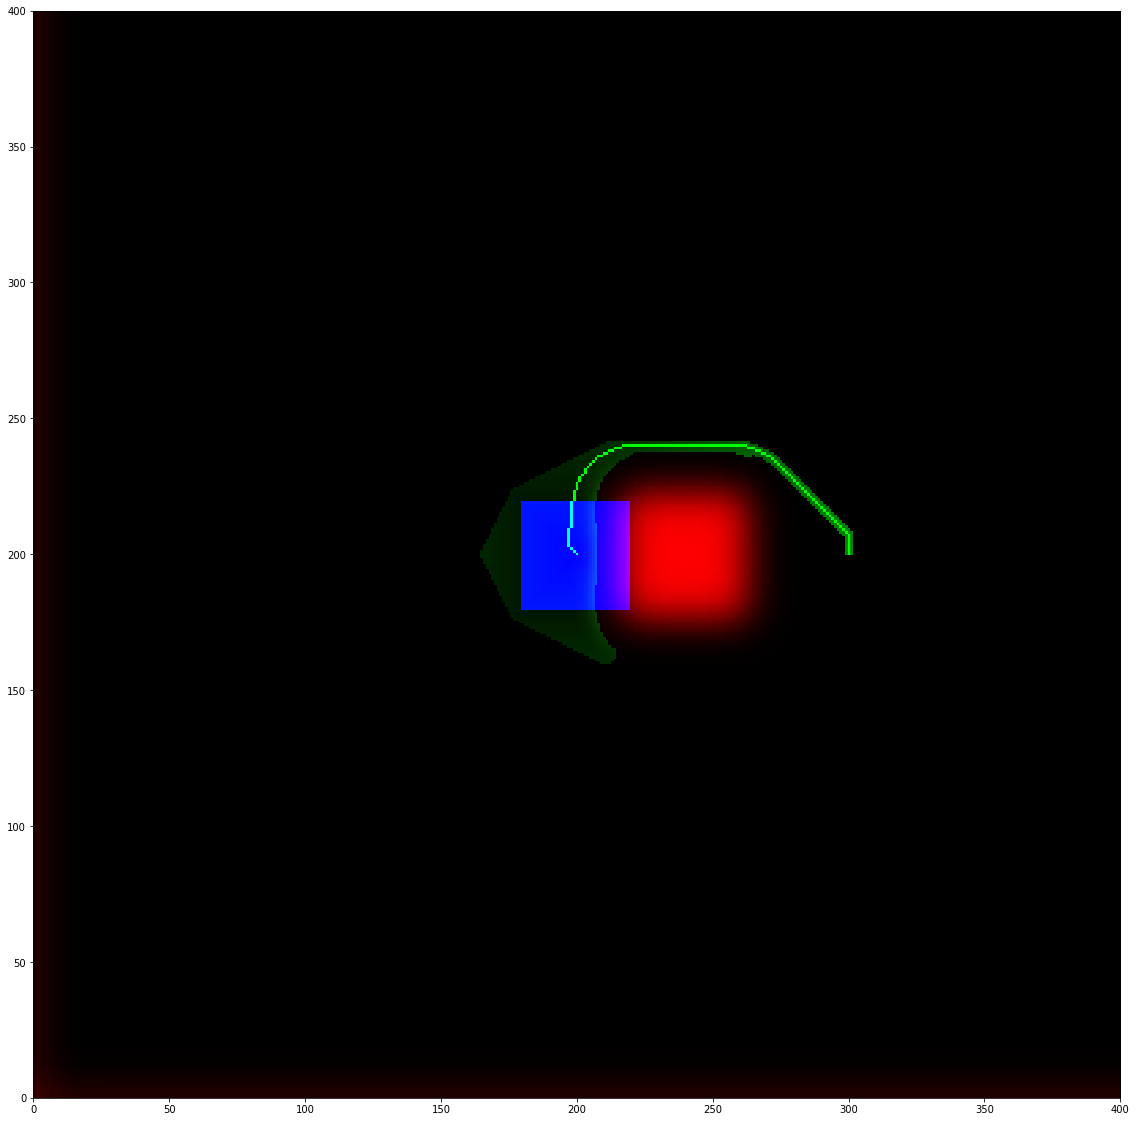

In [6]:
import robot as Robot
from Astar import *
from Mapping import *
import numpy as np
import matplotlib.pyplot as plt
from parse import *
%matplotlib inline
mapper = Mapping()
robot = Robot.robot(2000,2000,0)

mapper.new_obstacle( robot, "FRONT")

grid_updated=mapper.map()
Get_Pos=robot.get_position()
path, cost , G = AStarSearch((Get_Pos[0],Get_Pos[1]), (0,2000), grid_updated)
checkpoint = find_vertice(path)
print(checkpoint)
print(robot.x,robot.y)
#robot.set_position(3000,2000,0)
#mapper.new_obstacle(robot, "RIGHT")


new_x,newy,theta_robot = checkpoint_in_fov(robot,checkpoint)
robot.set_position(new_x,newy,theta_robot)
Get_Pos=robot.get_position()
path, cost , G = AStarSearch((Get_Pos[0],Get_Pos[1]), (3000,2000), grid_updated)
checkpoint = find_vertice(path)
print(checkpoint)
corrected_checkpoint = checkpoint_corrector(checkpoint)    
mapper.display(G,path,robot)



In [2]:
XY =[[1980, 2130],
 [1980 ,2190],
 [1990, 2230],
 [2000 ,2260],
 [2030 ,2300],
 [2100, 2370],
 [2160, 2390],
 [2620, 2400],
 [2670, 2380],
 [3000, 2070],
 [3000, 2000]]

corrected_checkpoint = checkpoint_corrector(XY)       

[[2030 2300]
 [2160 2390]
 [2670 2380]
 [3000 2000]]


In [6]:
print(checkpoint_corrector(robot,checkpoint))

[[1850 2000]
 [1850 2000]
 [1970 2030]
 [1970 2090]
 [1980 2190]
 [1990 2230]
 [2000 2260]
 [2030 2300]
 [2100 2370]
 [2160 2390]
 [2620 2400]
 [2670 2380]
 [3000 2070]
 [3000 2000]]


C:\Users\bot_\OneDrive\Documents\GitHub\STI_Robotic_Competition_Software\Architecture\Astar.py:156: RuntimeWarning: invalid value encountered in double_scalars
  theta = math.degrees(math.acos((v2[0]*v1[0]+v2[1]*v1[1]) / v2_norm))


In [ ]:
mapper.display(G,path,robot)

In [ ]:
Map_Rewards is a map of rewards(aka bottle or special zone according to the time of the game)
Map_terrain is a map of obstacle and wall 

while(running)
    if(Robot_has_reached_final_position)
        Get_Interresting_Position_To_Go();
    Set_Of_Coordinate=Calculate_Path(Actual_Pos,Position_To_Go,Map_terrain)
    for i in Set_Of_Coordinate
    #From here 
        Send set_of_Coordinate[i]
        Wait_for_answer
        Get_Position of the robot and state
        Actual_Pos=Correlation(Beacon,Robot_Pos)
        if State==Blocked
            Add_To_Map(Actual_Pos,Sensor_Trigged)
            break for loop
        else if State== Finished_Action
            continue
    #to here the robot can move
    Bottle_detection_behavior(Actual_Pos,Map_Rewards)

In [36]:
sensors_state = {'a':0,'b':0,'c':0,'d':0,'e':0,'f':0,'g':0,'h':0,'i':0,'j':0,'k':0,'l':0,'m':0}
mask = 1
fb_sensors = 
for sensor in  sensors_state:
    if fb_sensors&mask>0:
        sensors_state[sensor]=1
        
    mask = mask * 2
print(sensors_state)

{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': 0, 'g': 0, 'h': 0, 'i': 0, 'j': 0, 'k': 0, 'l': 0, 'm': 1}
